In [1]:
import numpy as np
import pandas as pd
import os
import cv2
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from keras.applications.inception_v3 import InceptionV3
from keras.utils import np_utils
from keras.optimizers import SGD

In [6]:
path = '../input/covid-face-mask-detection-dataset/'

#when you runing the code only change the directory path

In [7]:
# source dirs
train_path = path + 'New Masks Dataset/Train'
test_path = path + 'New Masks Dataset/Test'
val_path = path + 'New Masks Dataset/Validation'

In [9]:
# create training data generators 
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
        samplewise_center=True,
        rescale=1./127.5,
        )

# create testing and validation data generator without augmentation
test_val_datagen = tf.keras.preprocessing.image.ImageDataGenerator(samplewise_center=True, rescale=1./127.5)

In [10]:
BATCH_SIZE = 32
# this is the default size used by most of the pretrained Keras models
image_size = (224, 224)

# our dataset has two classes: images with face mask and without, so our task is a binary classification problem
train_ds = train_datagen.flow_from_directory(
        train_path, target_size=image_size, batch_size=BATCH_SIZE)#, class_mode='binary')
val_ds = test_val_datagen.flow_from_directory(
        val_path, target_size=image_size, batch_size=BATCH_SIZE)#, class_mode='binary')
test_ds = test_val_datagen.flow_from_directory( test_path, target_size=image_size, batch_size=BATCH_SIZE)#, class_mode='binary')

Found 600 images belonging to 2 classes.
Found 306 images belonging to 2 classes.
Found 100 images belonging to 2 classes.


In [8]:
train_ds.class_indices


{'Mask': 0, 'Non Mask': 1}

In [9]:
train_ds.class_mode

'categorical'

In [10]:
len(train_ds.classes)

600

In [ ]:
import tensor

In [11]:

# We are using InceptionV3 pre-trained model and a fully connected top layer for our classification.

model_pretrained = InceptionV3(weights='imagenet', 
                      include_top=False, 
                      input_shape=(224,224,3))

model=keras.models.Sequential()
model.add(model_pretrained)
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(300, activation="relu"))
model.add(keras.layers.Dropout(0.5))
model.add(keras.layers.Dense(100,activation='relu'))
model.add(keras.layers.Dropout(0.5))
model.add(keras.layers.Dense(2,activation="sigmoid"))


87910968/87910968 [==============================] - 1s 0us/step


In [12]:
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 5, 5, 2048)        21802784  
                                                                 
 flatten (Flatten)           (None, 51200)             0         
                                                                 
 dense (Dense)               (None, 300)               15360300  
                                                                 
 dropout (Dropout)           (None, 300)               0         
                                                                 
 dense_1 (Dense)             (None, 100)               30100     
                                                                 
 dropout_1 (Dropout)         (None, 100)               0         
                                                                 
 dense_2 (Dense)             (None, 2)                 2

In [13]:
# Time based learning rate scheduling
epoch=50
learning_rate=0.01
decay_rate=learning_rate/epoch
momentum=0.8
sgd=SGD(lr=learning_rate,momentum=momentum,decay=decay_rate)

/opt/conda/lib/python3.7/site-packages/keras/optimizers/optimizer_v2/gradient_descent.py:108: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


In [14]:
# Early stopping callback
callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

In [16]:
# compiling the model 
model.compile(loss='binary_crossentropy',
              optimizer=sgd,
              metrics=['accuracy'])

In [17]:
# Training stops after 9 epochs due to early stopping
model_history= model.fit(train_ds,batch_size=32,epochs=epoch,validation_data=(val_ds),shuffle=True, callbacks=[callback])

Epoch 1/50
19/19 [==============================] - 39s 1s/step - loss: 0.4615 - accuracy: 0.8333 - val_loss: 0.1959 - val_accuracy: 0.9477
Epoch 2/50
19/19 [==============================] - 13s 665ms/step - loss: 0.0305 - accuracy: 0.9917 - val_loss: 1.0828 - val_accuracy: 0.8203
Epoch 3/50
19/19 [==============================] - 12s 649ms/step - loss: 0.0355 - accuracy: 0.9900 - val_loss: 6.1942 - val_accuracy: 0.5131
Epoch 4/50
19/19 [==============================] - 13s 667ms/step - loss: 0.0187 - accuracy: 0.9983 - val_loss: 0.8090 - val_accuracy: 0.8791
Epoch 5/50
19/19 [==============================] - 12s 640ms/step - loss: 0.0231 - accuracy: 0.9933 - val_loss: 1.0048 - val_accuracy: 0.8301
Epoch 6/50
19/19 [==============================] - 12s 652ms/step - loss: 0.0306 - accuracy: 0.9983 - val_loss: 0.1722 - val_accuracy: 0.9608
Epoch 7/50
19/19 [==============================] - 13s 683ms/step - loss: 0.0110 - accuracy: 0.9983 - val_loss: 0.4989 - val_accuracy: 0.9248
Ep

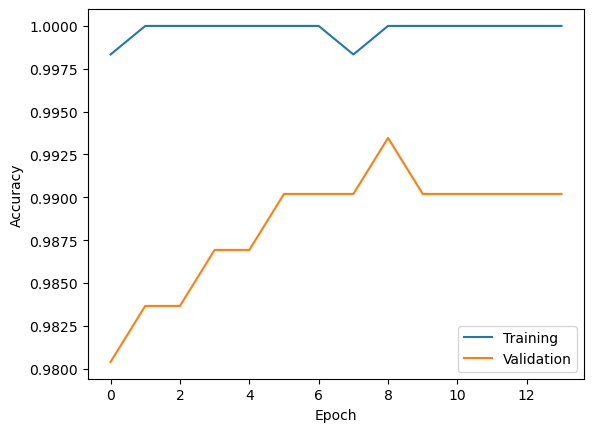

In [19]:
plt.plot(model_history.history['accuracy'])
plt.plot(model_history.history['val_accuracy'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Training', 'Validation'])
plt.show()

In [18]:
# Testing the model
loss, acc= model.evaluate(test_ds)
print('Loss:', loss)
print('Accuracy:', acc)

4/4 [==============================] - 3s 674ms/step - loss: 0.0252 - accuracy: 1.0000
Loss: 0.025213710963726044
Accuracy: 1.0


In [20]:
#saving the model
model.save("/kaggle/working/dnn_model.zip")

In [23]:
!pwd

/bin/bash: /opt/conda/lib/libtinfo.so.6: no version information available (required by /bin/bash)
/kaggle/working


In [22]:
from IPython.display import FileLink
FileLink('dnn_model.zip')

ValueError: Cannot display a directory using FileLink. Use FileLinks to display 'dnn_model.zip'.